# Sector Correlation Indicator

Measures rolling correlation between stock and its sector ETF.

**Values:**
- +1: Perfect positive correlation
- 0: No correlation  
- -1: Perfect negative correlation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from indikator import sector_correlation

plt.style.use("seaborn-v0_8-darkgrid")
np.random.seed(42)

## Scenario 1: High Correlation (Stock Moves with Sector)

/tmp/sselcuk/ipykernel_1244559/3078150631.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


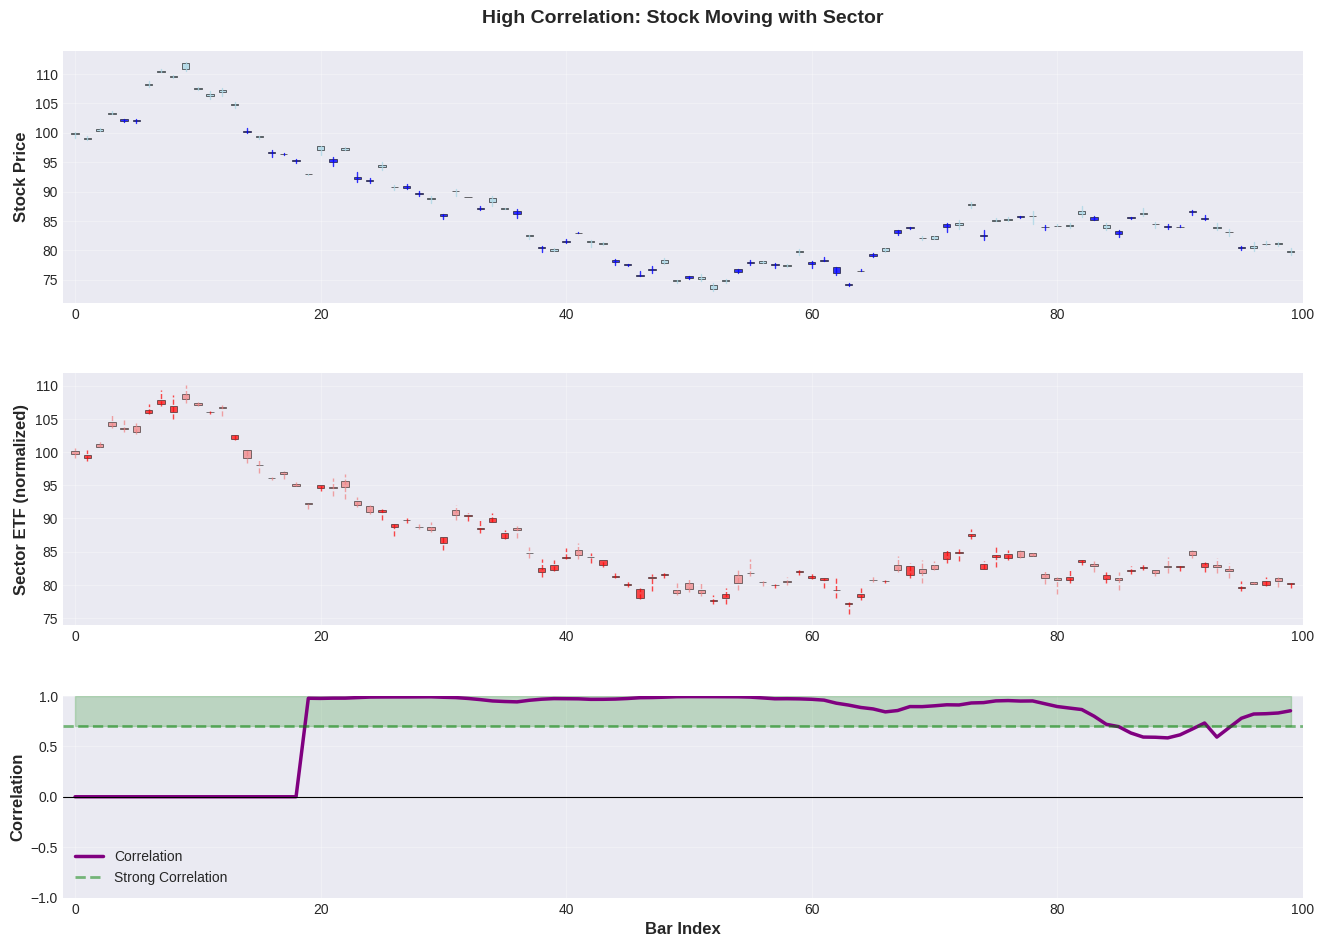

Average correlation: 0.730
High correlation means stock-specific risk is low


In [2]:
# Create correlated stock and sector data
n = 100
dates = pd.date_range('2024-01-01 09:30', periods=n, freq='5min')

sector_returns = np.random.randn(n) * 0.02
sector_prices = 1000 * np.exp(np.cumsum(sector_returns))

# Stock mostly follows sector with some noise
stock_returns = sector_returns * 1.2 + np.random.randn(n) * 0.01
stock_prices = 100 * np.exp(np.cumsum(stock_returns))

# Create OHLC for stock
stock_opens = stock_prices + np.random.randn(n) * 0.3
stock_highs = np.maximum(stock_opens, stock_prices) + np.abs(np.random.randn(n)) * 0.4
stock_lows = np.minimum(stock_opens, stock_prices) - np.abs(np.random.randn(n)) * 0.4
stock_volumes = 1000 + np.abs(np.random.randn(n)) * 200

# Create OHLC for sector
sector_opens = sector_prices + np.random.randn(n) * 5
sector_highs = np.maximum(sector_opens, sector_prices) + np.abs(np.random.randn(n)) * 8
sector_lows = np.minimum(sector_opens, sector_prices) - np.abs(np.random.randn(n)) * 8

stock_df = pd.DataFrame({'open': stock_opens, 'high': stock_highs, 'low': stock_lows, 'close': stock_prices, 'volume': stock_volumes}, index=dates)
sector_df = pd.DataFrame({'open': sector_opens, 'high': sector_highs, 'low': sector_lows, 'close': sector_prices}, index=dates)

result = sector_correlation(stock_df["close"], sector_df["close"], window=20)

# Plot
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 11))
gs = GridSpec(3, 1, height_ratios=[2.5, 2.5, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Stock candlesticks
for i in range(len(stock_df)):
    color = 'blue' if stock_df['close'].iloc[i] >= stock_df['open'].iloc[i] else 'lightblue'
    ax1.plot([i, i], [stock_df['low'].iloc[i], stock_df['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(stock_df['close'].iloc[i] - stock_df['open'].iloc[i])
    if height < 0.02: height = 0.05
    bottom = min(stock_df['open'].iloc[i], stock_df['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

ax1.set_ylabel('Stock Price', fontsize=12, fontweight='bold')
ax1.set_title('High Correlation: Stock Moving with Sector', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(stock_df))

# Sector candlesticks (scaled for comparison)
sector_normalized = sector_df['close'] / sector_df['close'].iloc[0] * stock_df['close'].iloc[0]
sector_opens_norm = sector_df['open'] / sector_df['close'].iloc[0] * stock_df['close'].iloc[0]
sector_highs_norm = sector_df['high'] / sector_df['close'].iloc[0] * stock_df['close'].iloc[0]
sector_lows_norm = sector_df['low'] / sector_df['close'].iloc[0] * stock_df['close'].iloc[0]

for i in range(len(sector_df)):
    color = 'red' if sector_df['close'].iloc[i] >= sector_df['open'].iloc[i] else 'lightcoral'
    ax2.plot([i, i], [sector_lows_norm.iloc[i], sector_highs_norm.iloc[i]], color=color, linewidth=1, alpha=0.7, linestyle='--')
    height = abs(sector_normalized.iloc[i] - sector_opens_norm.iloc[i])
    if height < 0.02: height = 0.05
    bottom = min(sector_opens_norm.iloc[i], sector_normalized.iloc[i])
    ax2.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.7))

ax2.set_ylabel('Sector ETF (normalized)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(sector_df))

# Correlation
corr_vals = result.values
ax3.plot(range(len(corr_vals)), corr_vals, 'purple', linewidth=2.5, label='Correlation')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(0.7, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Strong Correlation')
ax3.fill_between(range(len(result)), 0.7, 1, alpha=0.2, color='green')
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Correlation', fontsize=12, fontweight='bold')
ax3.set_ylim(-1, 1)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(result))

plt.tight_layout()
plt.show()

avg_corr = result.dropna().mean()
print(f"Average correlation: {avg_corr:.3f}")
print("High correlation means stock-specific risk is low")

## Scenario 2: Decoupling (Stock Goes Its Own Way)

/tmp/sselcuk/ipykernel_1244559/2845213445.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


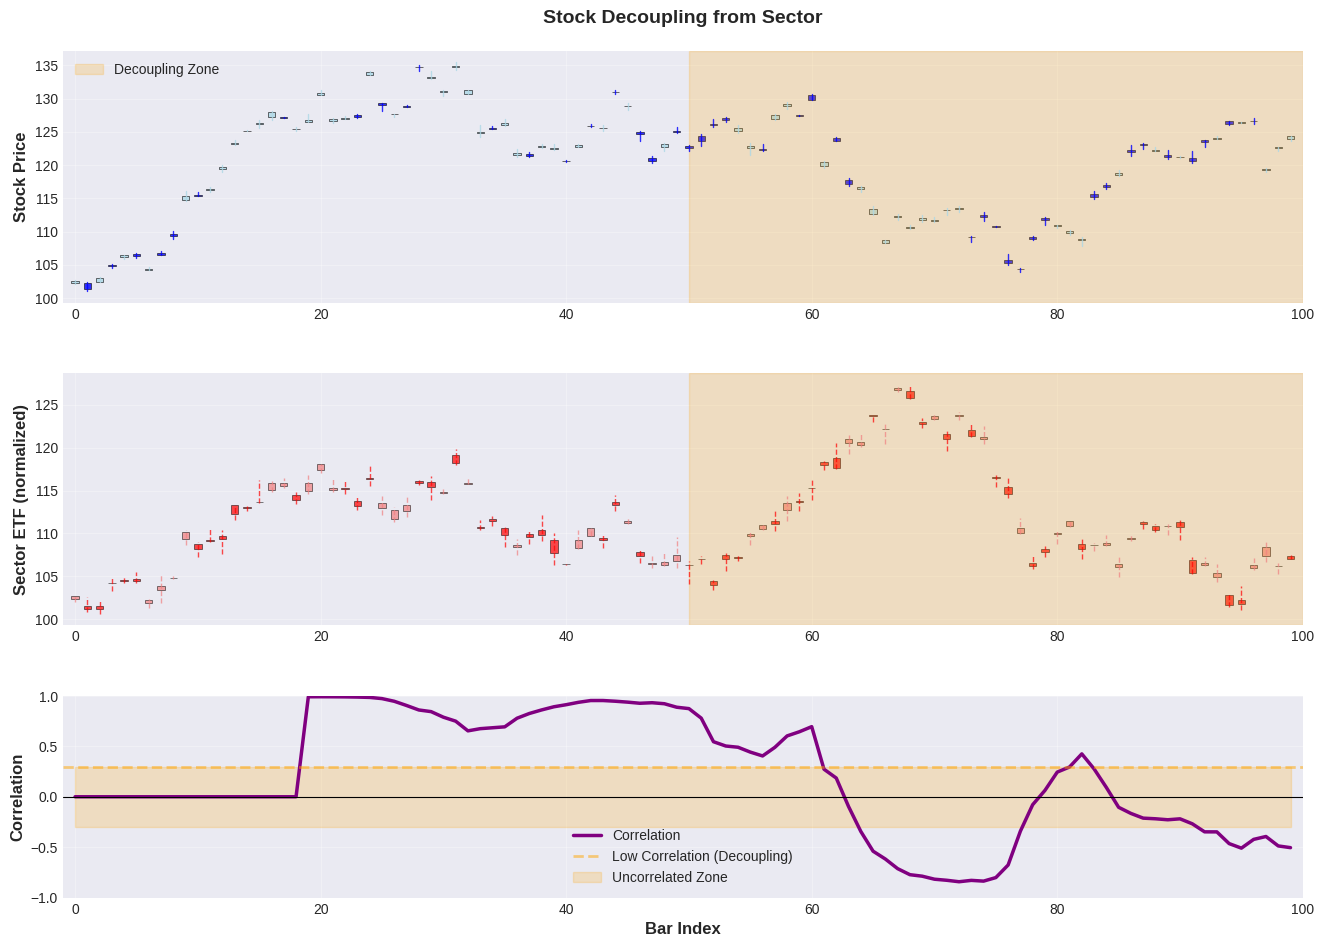

Correlation before decoupling (bars 0-50): 0.846
Correlation after decoupling (bars 50-100): -0.318

Low correlation indicates stock-specific factors dominating!


In [3]:
# Create data where stock decouples from sector
n2 = 100
dates2 = pd.date_range('2024-01-01 09:30', periods=n2, freq='5min')

sector_returns2 = np.random.randn(n2) * 0.02
sector_prices2 = 1000 * np.exp(np.cumsum(sector_returns2))

# Stock follows sector initially, then decouples
stock_returns2 = np.concatenate([
    sector_returns2[:50] * 1.2 + np.random.randn(50) * 0.01,  # Correlated
    np.random.randn(50) * 0.03,  # Decoupled (stock-specific movement)
])
stock_prices2 = 100 * np.exp(np.cumsum(stock_returns2))

# Create OHLC for stock
stock_opens2 = stock_prices2 + np.random.randn(n2) * 0.3
stock_highs2 = np.maximum(stock_opens2, stock_prices2) + np.abs(np.random.randn(n2)) * 0.4
stock_lows2 = np.minimum(stock_opens2, stock_prices2) - np.abs(np.random.randn(n2)) * 0.4
stock_volumes2 = 1000 + np.abs(np.random.randn(n2)) * 200

# Create OHLC for sector
sector_opens2 = sector_prices2 + np.random.randn(n2) * 5
sector_highs2 = np.maximum(sector_opens2, sector_prices2) + np.abs(np.random.randn(n2)) * 8
sector_lows2 = np.minimum(sector_opens2, sector_prices2) - np.abs(np.random.randn(n2)) * 8

stock_df2 = pd.DataFrame({'open': stock_opens2, 'high': stock_highs2, 'low': stock_lows2, 'close': stock_prices2, 'volume': stock_volumes2}, index=dates2)
sector_df2 = pd.DataFrame({'open': sector_opens2, 'high': sector_highs2, 'low': sector_lows2, 'close': sector_prices2}, index=dates2)

result2 = sector_correlation(stock_df2["close"], sector_df2["close"], window=20)

# Plot
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 11))
gs = GridSpec(3, 1, height_ratios=[2.5, 2.5, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Stock candlesticks
for i in range(len(stock_df2)):
    color = 'blue' if stock_df2['close'].iloc[i] >= stock_df2['open'].iloc[i] else 'lightblue'
    ax1.plot([i, i], [stock_df2['low'].iloc[i], stock_df2['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(stock_df2['close'].iloc[i] - stock_df2['open'].iloc[i])
    if height < 0.02: height = 0.05
    bottom = min(stock_df2['open'].iloc[i], stock_df2['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

ax1.axvspan(50, 100, alpha=0.2, color='orange', label='Decoupling Zone')
ax1.set_ylabel('Stock Price', fontsize=12, fontweight='bold')
ax1.set_title('Stock Decoupling from Sector', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(stock_df2))

# Sector candlesticks (scaled)
sector_normalized2 = sector_df2['close'] / sector_df2['close'].iloc[0] * stock_df2['close'].iloc[0]
sector_opens_norm2 = sector_df2['open'] / sector_df2['close'].iloc[0] * stock_df2['close'].iloc[0]
sector_highs_norm2 = sector_df2['high'] / sector_df2['close'].iloc[0] * stock_df2['close'].iloc[0]
sector_lows_norm2 = sector_df2['low'] / sector_df2['close'].iloc[0] * stock_df2['close'].iloc[0]

for i in range(len(sector_df2)):
    color = 'red' if sector_df2['close'].iloc[i] >= sector_df2['open'].iloc[i] else 'lightcoral'
    ax2.plot([i, i], [sector_lows_norm2.iloc[i], sector_highs_norm2.iloc[i]], color=color, linewidth=1, alpha=0.7, linestyle='--')
    height = abs(sector_normalized2.iloc[i] - sector_opens_norm2.iloc[i])
    if height < 0.02: height = 0.05
    bottom = min(sector_opens_norm2.iloc[i], sector_normalized2.iloc[i])
    ax2.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.7))

ax2.axvspan(50, 100, alpha=0.2, color='orange')
ax2.set_ylabel('Sector ETF (normalized)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(sector_df2))

# Correlation
corr = result2.values
ax3.plot(range(len(corr)), corr, 'purple', linewidth=2.5, label='Correlation')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(0.3, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Low Correlation (Decoupling)')
ax3.fill_between(range(len(result2)), -0.3, 0.3, alpha=0.2, color='orange', label='Uncorrelated Zone')
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Correlation', fontsize=12, fontweight='bold')
ax3.set_ylim(-1, 1)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(result2))

plt.tight_layout()
plt.show()

print(f"Correlation before decoupling (bars 0-50): {result2.iloc[30:50].mean():.3f}")
print(f"Correlation after decoupling (bars 50-100): {result2.iloc[70:].mean():.3f}")
print("\nLow correlation indicates stock-specific factors dominating!")

## Scenario 3: Window Parameter Effect

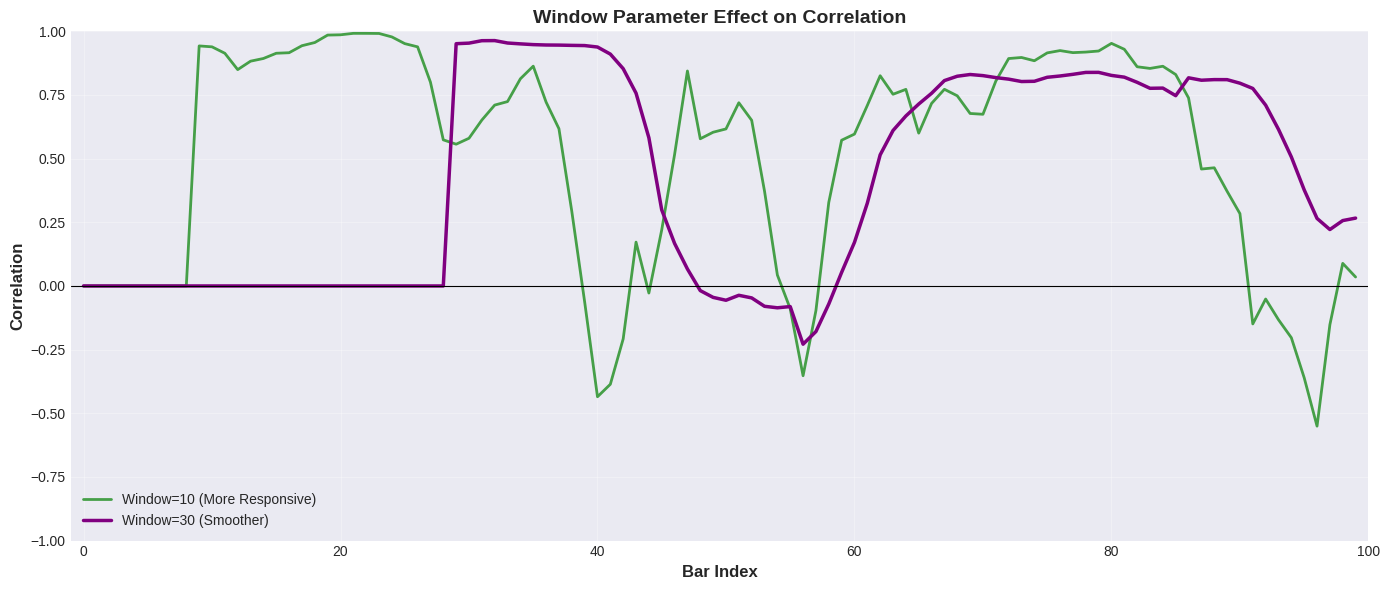

Smaller window detects short-term correlation changes
Larger window provides more stable long-term correlation


In [4]:
# Create varying correlation data
n3 = 100
dates3 = pd.date_range('2024-01-01 09:30', periods=n3, freq='5min')

sector_ret = np.random.randn(n3) * 0.02
stock_ret = np.zeros(n3)
for i in range(n3):
    # Correlation changes over time
    corr_factor = 0.5 + 0.4 * np.sin(i / 10)
    stock_ret[i] = sector_ret[i] * corr_factor + np.random.randn() * 0.01

stock_prices3 = 100 * np.exp(np.cumsum(stock_ret))
sector_prices3 = 1000 * np.exp(np.cumsum(sector_ret))

# Create OHLC for stock
stock_opens3 = stock_prices3 + np.random.randn(n3) * 0.3
stock_highs3 = np.maximum(stock_opens3, stock_prices3) + np.abs(np.random.randn(n3)) * 0.4
stock_lows3 = np.minimum(stock_opens3, stock_prices3) - np.abs(np.random.randn(n3)) * 0.4

# Create OHLC for sector
sector_opens3 = sector_prices3 + np.random.randn(n3) * 5
sector_highs3 = np.maximum(sector_opens3, sector_prices3) + np.abs(np.random.randn(n3)) * 8
sector_lows3 = np.minimum(sector_opens3, sector_prices3) - np.abs(np.random.randn(n3)) * 8

stock_df3 = pd.DataFrame({'close': stock_prices3, 'open': stock_opens3, 'high': stock_highs3, 'low': stock_lows3}, index=dates3)
sector_df3 = pd.DataFrame({'close': sector_prices3, 'open': sector_opens3, 'high': sector_highs3, 'low': sector_lows3}, index=dates3)

result_w10 = sector_correlation(stock_df3["close"], sector_df3["close"], window=10)
result_w30 = sector_correlation(stock_df3["close"], sector_df3["close"], window=30)

fig, ax = plt.subplots(figsize=(14, 6))

# Use integer indices for x-axis
w10_vals = result_w10.values
w30_vals = result_w30.values

ax.plot(
    range(len(w10_vals)),
    w10_vals,
    'green',
    linewidth=2,
    alpha=0.7,
    label='Window=10 (More Responsive)',
)
ax.plot(
    range(len(w30_vals)),
    w30_vals,
    'purple',
    linewidth=2.5,
    label='Window=30 (Smoother)',
)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Correlation', fontsize=12, fontweight='bold')
ax.set_title('Window Parameter Effect on Correlation', fontsize=14, fontweight='bold')
ax.set_ylim(-1, 1)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-1, len(stock_df3))

plt.tight_layout()
plt.show()

print("Smaller window detects short-term correlation changes")
print("Larger window provides more stable long-term correlation")

## Key Takeaways

**High Correlation (>0.7):**
- Stock moves with sector
- Sector factors dominate
- Lower stock-specific risk

**Low Correlation (<0.3):**
- Stock has own drivers
- Company-specific news/events
- Higher idiosyncratic risk

**Use Cases:**
- **Risk management**: Diversification analysis
- **Trading**: Identify decoupling opportunities
- **Portfolio construction**: Sector exposure assessment

## Feature Showcase: Safety & Configuration

In [5]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator import sector_correlation

# 1. Configuration with .Config()
print(f"--- Custom sector_correlation Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_sector_correlation = sector_correlation.Config(window=30).make()
print(f"Created: {custom_sector_correlation}")

# 2. Validation Safety
print(f"--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (schema validation)
    invalid_data = pd.DataFrame({'close': [100]}) # Missing sector data
    print("Attempting calculation with invalid inputs...")
    sector_correlation(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected: {e}")


--- Custom sector_correlation Configuration ---
Created: sector_correlation(window=30, default_value=0.0)
--- Input Validation Safety ---
Attempting calculation with invalid inputs...
✓ Validator caught error as expected: Type mismatch for parameter 'stock_data' in 'sector_correlation': expected Series, got DataFrame
